#Importing Packages

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import inspect
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

#Reading Datasets

In [11]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
ROOT_DIR = "/content/drive/Shareddrives/CIS522/"

with open(ROOT_DIR+"imgs.npy", "rb") as f:
  imgs = np.load(f)

with open(ROOT_DIR+"labels.npy", "rb") as f:
  labels = np.load(f)

#Creating Data Loaders

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    imgs, 
    labels, 
    test_size=0.1, 
    random_state=42
  )

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=42
  )

def reshape_arrays(arr):
  return arr.reshape((arr.shape[0], 1, arr.shape[1], arr.shape[2]))

X_train = reshape_arrays(X_train)
X_val = reshape_arrays(X_val)
X_test = reshape_arrays(X_test)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((9478, 1, 224, 224),
 (1054, 1, 224, 224),
 (1171, 1, 224, 224),
 (9478,),
 (1054,),
 (1171,))

In [25]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
X_test = torch.Tensor(X_test)

y_train = torch.Tensor(y_train)
y_val = torch.Tensor(y_val)
y_test = torch.Tensor(y_test)

train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test, batch_size=32, shuffle=False)

#Network Architecture

In [15]:
class MobileNet(nn.Module):
  def __init__(self, in_channels=1):
    super(MobileNet, self).__init__()
    
    self.conv = nn.Conv2d(in_channels, out_channels=3, kernel_size=5, padding=2)
    self.model = models.mobilenet_v2(pretrained=True)
    self.fc = nn.Linear(in_features=1000, out_features=3)

  def forward(self, x):
    x = self.conv(x)
    x = F.relu(self.model(x))
    return self.fc(x)

mobilenet = MobileNet()

In [16]:
input = torch.randn((16,1,244,244))
output = mobilenet(input)
print(output.shape)

print(mobilenet)

torch.Size([16, 3])
MobileNet(
  (conv): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (model): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequentia

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

#Helper Functions for Evaluation

In [18]:
def calculate_metric(metric_fn, true_y, pred_y):
  if metric_fn == accuracy_score:
    return metric_fn(true_y, pred_y)
  else:
    return metric_fn(true_y, pred_y, average="macro")
    
def print_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

#Network Training

In [19]:
model = mobilenet.to(device)

epochs = 3

# loss function and optimizer
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

start_ts = time.time()

losses = []
batches = len(train_dataloader)
val_batches = len(val_dataloader)
best_loss = float("inf")

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
  total_loss = 0

  progress = tqdm(enumerate(train_dataloader), desc="Loss: ", total=batches)

  # ----------------- TRAINING  -------------------- 
  # set model to training
  model.train()
    
  for i, data in progress:
    X, y = data[0].to(device), data[1].to(device)
      
    # training step for single batch
    model.zero_grad()
    outputs = model(X)
    loss = loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
    loss.backward()
    optimizer.step()
      
    # getting training quality data
    current_loss = loss.item()
    total_loss += current_loss
      
    # updating progress bar
    progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
  # releasing unceseccary memory in GPU
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
  # ----------------- VALIDATION  ----------------- 
  val_losses = 0
  precision, recall, f1, accuracy = [], [], [], []
    
  # set model to evaluating (testing)
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(val_dataloader):
      X, y = data[0].to(device), data[1].to(device)
        
      outputs = model(X)
      
      val_losses += loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
        
      predicted_classes = torch.max(outputs, 1)[1]
        
      # calculate P/R/F1/A metrics for batch
      for acc, metric in zip((precision, recall, f1, accuracy), 
                             (precision_score, recall_score, f1_score, accuracy_score)):
          acc.append(
              calculate_metric(metric, y.cpu(), predicted_classes.cpu())
          )
  
  if (val_losses/val_batches)<best_loss:
    best_model = model
    best_loss = (val_losses/val_batches)

  print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
  print_scores(precision, recall, f1, accuracy, val_batches)
  losses.append(total_loss/batches) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 1/3, training loss: 0.08049378065319468, validation loss: 0.03604918718338013
	     precision: 0.9873
	        recall: 0.9897
	            F1: 0.9877
	      accuracy: 0.9886


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 2/3, training loss: 0.025957757211291524, validation loss: 0.014134753495454788
	     precision: 0.9939
	        recall: 0.9940
	            F1: 0.9936
	      accuracy: 0.9943


Loss:   0%|          | 0/297 [00:00<?, ?it/s]

Epoch 3/3, training loss: 0.0160048527006181, validation loss: 0.025972958654165268
	     precision: 0.9930
	        recall: 0.9925
	            F1: 0.9923
	      accuracy: 0.9933
Training time: 6211.750199317932s


#Network Evaluation on Test Data

In [26]:
test_losses = 0
precision, recall, f1, accuracy = [], [], [], []
test_batches = len(test_dataloader)
# set model to evaluating (testing)
best_model.eval()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    X, y = data[0].to(device), data[1].to(device)
        
    outputs = best_model(X)
      
    test_losses += loss_function(outputs, torch.tensor(y, dtype=torch.long, device=device))
        
    predicted_classes = torch.max(outputs, 1)[1]
        
    # calculate P/R/F1/A metrics for batch
    for acc, metric in zip((precision, recall, f1, accuracy), 
                           (precision_score, recall_score, f1_score, accuracy_score)):
        acc.append(
            calculate_metric(metric, y.cpu(), predicted_classes.cpu())
        )
print(f"training loss: {total_loss/batches}, testing loss: {test_losses/test_batches}")
print_scores(precision, recall, f1, accuracy, test_batches)

training loss: 0.0160048527006181, testing loss: 0.04913406819105148
	     precision: 0.9911
	        recall: 0.9882
	            F1: 0.9890
	      accuracy: 0.9893


#Learning Curve

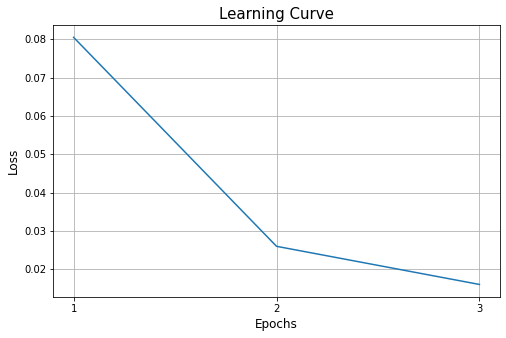

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1, 4)), losses)
ax.set_xlabel("Epochs", size=12)
ax.set_ylabel("Loss", size=12)
ax.set_title("Learning Curve", size=15)
ax.set_xticks(list(range(1, 4)))
ax.grid()
plt.show()